# Assignment 05
EE 538 Spring 2020 <br>
Analog Circuits for Sensor Systems <br>
University of Washington Electrical & Computer Engineering <br>

Due: May 9, 2020 <br>
Author: Kevin Egedy

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [3]:
def read_ltspice_wc(file_name):
    lines = []
    with open(file_name) as fh:
        for line in fh:
            if line.startswith("Step Information:"): continue
            lines.append(line)
    cols = []
    arrs = []
    for i,line in enumerate(lines):
        if i==0:
            cols = line.split()
            arrs = [[] for _ in cols]
            continue
        parts = line.split()
        for j,part in enumerate(parts):
            arrs[j].append(part)
    df = pd.DataFrame(arrs)
    df = df.T
    df.columns = cols
    return df

<img src="images/HW05Q1.png" width="600">

*Reference:http://leachlegacy.ece.gatech.edu/ece3050/sp04/OpAmps01.pdf*

**Differential Amplifier Stage**

$\begin{eqnarray}
&& Z_{\text{in}} &=& \frac{\Delta V_{id}}{\Delta(i^{-}-i^{+})} &=&
R_i(1+\frac{R_i}{R_f}) \\[0.5em]
&& \frac{-V_{id}}{2} &=& i^{-}(R_i+R_f) &\rightarrow& 
i^{-} = \frac{-V_{id}}{2(R_i+R_f)} \\[0.5em]
&& v^{-} &=& v^{+} &=& i^{-}R_f \\[0.5em]
&& i^{+} &=& \frac{\frac{V_{id}}{2}-v^{-}}{R_1} \\[0.5em]
&& &=& \frac{\frac{V_{id}}{2}-\frac{-V_{id}}{2(R_i+R_f)}R_f}{R_1} \\[0.5em]
&& &=& \frac{V_{id}}{2} [\frac{1+\frac{R_f}{(R_i+R_f)}}{R_1}] \\[0.5em]
&& &=& \frac{V_{id}}{2} [\frac{(R_i+R_f)+R_f}{R_1(R_i+R_f)}] \\[0.5em]
&& i^{-}-i^{+} &=& \frac{-V_{id}}{2(R_i+R_f)} + 
\frac{V_{id}}{2} [\frac{(R_i+R_f)+R_f}{R_1(R_i+R_f)}] \\[0.5em]
&& &=& \frac{V_{id}}{2} [\frac{(R_i+R_f)+R_f}{R_1(R_i+R_f)}- 
\frac{1}{R_i+R_f}] \\[0.5em]
&& &=& \frac{V_{id}}{2(R_i+R_f)} [\frac{(R_i+R_f)+R_f}{R_1}-1] \\[0.5em]
&& &=& \frac{V_{id}}{2R_i(R_i+R_f)} [R_i+R_f+R_f-R_i] \\[0.5em]
&& &=& \frac{V_{id}}{2R_i(R_i+R_f)} [2R_f] \\[0.5em]
&& &=& V_{id} \frac{R_f}{R_i(R_i+R_f)} \\[0.5em]
&& Z_{\text{in}} &=& \frac{\Delta V_{id}}{\Delta(i^{-}-i^{+})}  \\[0.5em]
&& &=& \frac{V_{id}}{V_{id} \frac{R_f}{R_i (R_i+R_f)}} \\[0.5em]
&& &=& \frac{R_i (R_i+R_f)}{R_f} = R_i(1+\frac{R_i}{R_f}) \\[0.5em]
&& &=& 101 \Omega
\end{eqnarray}$

<hr>

**0.1% Attenuation**

$\begin{eqnarray}
V_{\text{out}} = v_S \frac{Z_{\text{in}}}{R_S + Z_{\text{in}}} \\[0.5em]
0.999 = \frac{101}{R_S+101} \\[0.5em]
R_S = 0.10 \Omega
\end{eqnarray}$

<hr>

**Part B**

In [4]:
filepath = 'data/diff_amp_relationship.txt'
df = read_ltspice(filepath,'ac')
mag1 = df['Mag_(V(vp)-V(vm))/(I(R1)-I(R4))']
ang1 = df['Phase_(V(vp)-V(vm))/(I(R1)-I(R4))']
mag2 = df['Mag_V(vout)/(V(vp)-V(vm))']
ang2 = df['Phase_V(vout)/(V(vp)-V(vm))']
freq = df['Freq.']

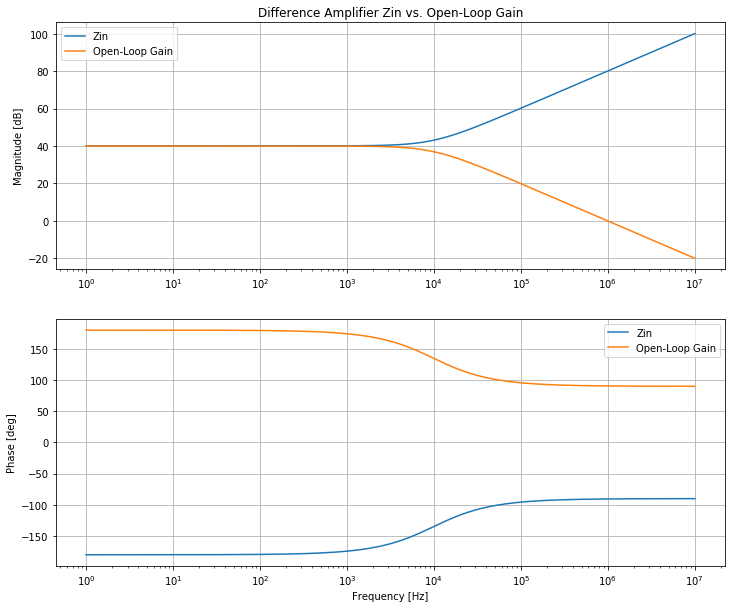

In [5]:
#Plot
fig, axs = plt.subplots(2,figsize=(12,10))
axs[0].set_title('Difference Amplifier Zin vs. Open-Loop Gain')
axs[0].semilogx(freq, mag1, label='Zin')
axs[0].semilogx(freq, mag2, label='Open-Loop Gain')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()
axs[1].semilogx(freq, ang1, label='Zin')
axs[1].semilogx(freq, ang2, label='Open-Loop Gain')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Phase [deg]')
axs[1].grid()
axs[1].legend()
plt.show();

In [6]:
filepath = 'data/diff_amp.txt'
df = read_ltspice(filepath,'ac','cartesian')
mag = abs(df['Re_(V(vp)-V(vm))/(I(R1)-I(R4))'])
freq = df['Freq.']

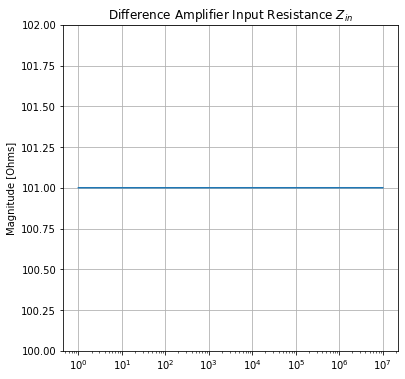

In [7]:
fig, ax = plt.subplots(1,figsize=(6,6))
ax.set_title(r'Difference Amplifier Input Resistance $Z_{in}$')
ax.semilogx(freq, mag)
ax.set_ylim(100,102)
ax.set_ylabel('Magnitude [Ohms]')
ax.grid()
#ax.legend()
plt.show();

<img src="images/HW05Q2.png" width="600">

**Part A**

simple non-inverting

$\begin{eqnarray}
&& -V_{\text{out}} &=& (v^{-}-v^{+})A_{OL} \\[0.5em]
&& v^{-} &=& \frac{-V_{\text{out}}}{A_{OL}}+v^{+} \\[0.5em]
&& i_1 &=& \frac{\frac{-V_{\text{out}}}{A_{OL}}+v_{\text{in}}}{R_G} \\[0.5em]
&& V_{\text{out}} &=& v^{-} + i_1 R_f \\[0.5em]
&& V_{\text{out}} &=& \frac{-V_{\text{out}}}{A_{OL}}+v_{\text{in}} +
\frac{\frac{-V_{\text{out}}}{A_{OL}}+v_{\text{in}}}{R_G}R_f \\[0.5em]
&& V_{\text{out}}+\frac{V_{\text{out}}}{A_{OL}}+
\frac{V_{\text{out}}R_f}{A_{OL}R_G} &=& v_{\text{in}}+
\frac{v_{\text{in}}R_f}{R_G}\\[0.5em]
&& V_{\text{out}}(1+\frac{1}{A_{OL}}+
\frac{R_f}{A_{OL}R_G} &=& v_{\text{in}}(1+
\frac{R_f}{R_G})\\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}}(A_{OL}+1+\frac{R_f}{R_G})
&=& v_{\text{in}}(1+\frac{R_f}{R_G})\\[0.5em]
&& V_{\text{out}}
&=& v_{\text{in}}\frac{A_{OL}(1+\frac{R_f}{R_G})}
{A_{OL}+(1+\frac{R_f}{R_G})}, 
\alpha = 1+\frac{R_f}{R_G}\\[0.5em]
&& &=& v_{\text{in}}\frac{A_{OL}\alpha}
{A_{OL}+\alpha} \\[0.5em]
&& &=& v_{\text{in}}\frac{A_{OL}}
{\frac{A_{OL}}{\alpha}+1}, 
\beta = \frac{1}{\alpha} \\[0.5em]
&& &=& v_{\text{in}}\frac{A_{OL}}
{A_{OL}\beta+1}, 
\beta = \frac{1}{1+\frac{R_f}{R_G}} 
\Bigg|_{R_f=4.95k, R_G=100} \\[0.5em]
\end{eqnarray}$

<hr>

Instrumentaion amplifier 1st Stage

$\begin{eqnarray}
&& I_G &=& \frac{V_p^- - V_m^-}{R_G} \\[0.5em]
&& V_{op} &=& \frac{-V_{\text{op}}}{A_{OL}}+v_{\text{ip}} +
I_G R_{fp} \\[0.5em]
&& &=& \frac{-V_{\text{op}}}{A_{OL}}+v_{\text{ip}} +
\frac{\frac{-V_{\text{op}}}{A_{OL}}+v_{\text{ip}}-(\frac{-V_{\text{om}}}{A_{OL}}+v_{\text{im}})}{R_G}R_{fp} \\[0.5em]
&&  &=& -\frac{V_{\text{op}}}{A_{OL}}(1+\frac{R_{fp}}{R_G}) + 
v_{\text{ip}}(1+\frac{R_{fp}}{R_G}) + 
\frac{V_{\text{om}}}{A_{OL}}\frac{R_{fp}}{R_G} -  
v_{\text{im}}\frac{R_{fp}}{R_G} \\[0.5em]
&& V_{om} &=& \frac{-V_{\text{om}}}{A_{OL}}+v_{\text{im}} +
I_G R_{fm} \\[0.5em]
&& &=& \frac{-V_{\text{om}}}{A_{OL}}+v_{\text{im}} +
\frac{\frac{-V_{\text{om}}}{A_{OL}}+v_{\text{im}}-(\frac{-V_{\text{op}}}{A_{OL}}+v_{\text{ip}})}{R_G}R_{fm} \\[0.5em]
&& &=& -\frac{V_{\text{om}}}{A_{OL}}(1+\frac{R_{fm}}{R_G}) + 
v_{\text{im}}(1+\frac{R_{fm}}{R_G}) + 
\frac{V_{\text{op}}}{A_{OL}}\frac{R_{fm}}{R_G} -  
v_{\text{ip}}\frac{R_{fm}}{R_G} \\[0.5em]
&& V_{op}-V_{om} &=&  -\frac{V_{\text{op}}}{A_{OL}}(1+\frac{R_{fp}+R_{fm}}{R_G}) + 
v_{\text{ip}}(1+\frac{R_{fp}+R_{fm}}{R_G}) + 
\frac{V_{\text{om}}}{A_{OL}}(1+\frac{R_{fp}+R_{fm}}{R_G}) - 
v_{\text{im}}(1+\frac{R_{fp}+R_{fm}}{R_G}) \\[0.5em]
&& V_{op}-V_{om} &=&  \frac{-(V_{\text{op}}-V_{\text{om}})}{A_{OL}}
(1+\frac{R_{fp}+R_{fm}}{R_G}) + 
(v_{\text{ip}}-v_{\text{im}})(1+\frac{R_{fp}+R_{fm}}{R_G}) \\[0.5em]
&& V_{\text{out}} &=& \frac{V_{op}-V_{om}}{v_{ip}-v_{im}} \\[0.5em]
&& &=& \frac{A_{OL}}
{A_{OL}\beta+1}, 
\beta = \frac{1}{1+\frac{R_{fp}+R_{fm}}{R_G}} \\[0.5em]
\end{eqnarray}$

<hr>

difference amp stage

given: $A_0 \rightarrow \infty$

<img src="images/HW05_diff_amp.png" width="300">

$\begin{eqnarray}
&& R_1 = R_2 = R_3 = R_4 = 10k\\[0.5em]
&& v_{\text{in}} = (v_{ip}+v_{im})\frac{A_{OL}}
{A_{OL}\beta+1}, 
\beta = \frac{1}{1+\frac{R_2}{R_1}} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \frac{v_{\text{in}}-\frac{V_{\text{out}}}{A_{OL}}}{R_1} &=& 
\frac{\frac{V_{\text{out}}}{A_{OL}}-V_{\text{out}}}{R_2} \\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}R_2} - \frac{V_{\text{out}}}{R_2} +
\frac{V_{\text{out}}}{A_{OL}R_1} &=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& V_{\text{out}}(\frac{1}{A_{OL}R_2} - \frac{1}{R_2} +
\frac{1}{A_{OL}R_1}) &=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}}(\frac{1}{R_2} - \frac{A_{OL}}{R_2} +
\frac{1}{R_1}) &=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}}(\frac{1-A_{OL}}{R_2} +
\frac{1}{R_1}) &=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}}\frac{(1-A_{OL})R_1+R_2}{R_1 R_2}
&=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& V_{\text{out}}\frac{R_1}{A_{OL}} [ \frac{1-A_{OL}+\frac{R_2}{R_1}}{R_1 R_2}]
&=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& \frac{V_{\text{out}}}{A_{OL}}\frac{1-A_{OL}+\frac{R_2}{R_1}}{R_2}
&=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& \frac{V_{\text{out}}}{-A_{OL}}\frac{A_{OL}-1-\frac{R_2}{R_1}}{R_2}
&=& \frac{v_{\text{in}}}{R_1} \\[0.5em]
&& V_{\text{out}}
&=& v_{\text{in}}A_{OL}\frac{\frac{-R_2}{R_1}}{A_{OL}-1-\frac{R_2}{R_1}}, \alpha =  \frac{-R_2}{R_1}\\[0.5em]
&& &=& v_{\text{in}}A_{OL}\frac{\alpha}{A_{OL}-1+\alpha} \\[0.5em]
&& &=& v_{\text{in}}A_{OL}\frac{1}{\frac{A_{OL}-1}{\alpha}+1} \\[0.5em]
&& &=& v_{\text{in}}A_{OL}\frac{1}{\beta (A_{OL}-1)+1}, 
\beta = \frac{1}{\alpha} = \frac{-R_1}{R_2}\Bigg|_{R_1=R_2=10k} \\[0.5em]
&& &\approx& v_{\text{in}}A_{OL}\frac{1}{ -A_{OL}+1}\Bigg|_{A_0 \rightarrow \infty} \\[0.5em]
&& &\approx& -v_{\text{in}} \\[0.5em]
\end{eqnarray}$

<hr>

**Differential DC Gain**

$\begin{eqnarray}
&& \frac{V_{\text{out}}}{v_{\text{in}}} &=& 
\frac{A_{OL}}{A_{OL}\beta+1}, 
\beta = \frac{1}{1+\frac{R_{fp}+R_{fm}}{R_G}}, A_{OL} = 10^6 \\[0.5em]
&& \frac{V_{\text{out}}}{v_{\text{in}}} &=&
\frac{10^6}{\frac{10^6}{100}+1} = 99.99 \frac{V}{V}
\end{eqnarray}$

**Frequency Response**

$\begin{eqnarray}
&& A_{OL}(s) &=& \frac{A_0}{1+s\tau }  \\[0.5em]
&& f_{3\text{dB},\text{OL}} &=& \frac{1}{\tau} = \frac{f_T}{A_0} \\[0.5em]
&& A_{CL}(s) &=& \frac{A_0}{1+s\tau + \beta A_0}  \\[0.5em]
&& f_{3\text{dB},\text{CL}} &=& \frac{\beta A_0}{\tau_{\text{OL}}} = \beta f_T 
\Bigg|_{f_T = 1\text{MHz}, \beta = 0.01}  = 10\text{kHz} \\[0.5em]
\end{eqnarray}$

<hr>

**Part B**

Given $f=100$Hz

$\begin{eqnarray}
&& \beta &=& \frac{1}{1+\frac{R_{fp}+R_{fm}}{R_G}}  = \frac{1}{100}\\[0.5em]
&& G_{\text{actual}} &=& A_{CL} = \frac{A_{OL}}{A_{OL}\beta+1} 
\Bigg|_{A_0=10^6} &=& 99.99\\[0.5em]
&& G_{\text{ideal}} &=& A_{CL}\Bigg|_{A_0 \rightarrow \infty} = \frac{1}{\beta} &=& 100\\[0.5em]
&& \delta_{G} &=& \frac{G_{\text{ideal}}-G_{\text{actual}}}{G_{\text{ideal}}} = 0.01\%
\end{eqnarray}$

<hr>

**Part C**

**Matched Resistors**

$\begin{eqnarray}
&& \text{CMMR} &=& \frac{A_{vd}}{A_{vcm}} \\[0.5em]
&& A_{vd1} &=& 1 + \frac{R_{fp}+R_{fm}}{R_G} 
\Bigg|_{R_{fp}=R_{fm}=4.95k, R_G=100}  &=& 100\\[0.5em]
&& A_{vd2} &=& \frac{R_2}{R_1} \Bigg|_{R_1 = R_2 = 10k} &=& 1\\[0.5em]
&& A_{vcm} &=& \frac{V_0}{V_{icm}} &=& 1 \\[0.5em]
&& \text{CMMR} &=& \text{CMMR}_1\cdot \text{CMMR}_2 \\[0.5em]
&& &=& [1+\frac{R_{fp}+R_{fm}}{R_G}] \cdot \frac{A_{vd2}+1}{4\epsilon} \\[0.5em]
&& &=& 100 \cdot \frac{1+1}{4\cdot 0.001} \\[0.5em]
&& &=& 50000 \approx 93.98\text{dB}\\[0.5em]
\end{eqnarray}$

**Worst Case CMMR**

$\begin{eqnarray}
&& A_{vd1} &=& 1 + \frac{R_{fp}+R_{fm}}{R_G} \\[0.5em]
&& &=& 1 + \frac{4.95k(1-0.001)+4.95k(1-0.001)}{100(1+0.001)} &=& 98.8\\[0.5em]
&& A_{vd2} &=& \frac{R_2}{R_1} \\[0.5em] 
&& &=& \frac{10k(1-0.001)}{10k(1+0.001)} &=& 0.998 \\[0.5em]
&& \text{CMMR} &=& \text{CMMR}_1\cdot \text{CMMR}_2 \\[0.5em]
&& &=& [1+\frac{R_{fp}+R_{fm}}{R_G}] \cdot \frac{A_{vd2}+1}{4\epsilon} \\[0.5em]
&& &=& 98.8 \cdot \frac{0.998+1}{4\cdot 0.001} \\[0.5em]
&& &=& 49350 \approx 93.87 \text{dB}\\[0.5em]
\end{eqnarray}$

<hr>

**Worst Case Gain Error**

$\begin{eqnarray}
&& \delta_{G} &=& \frac{G_{\text{ideal}}-G_{\text{actual}}}{G_{\text{ideal}}} = \frac{100-(98.8\cdot0.998)}{100} = 1.4\%
\end{eqnarray}$

<hr>

**Part D**

$\begin{eqnarray}
&& \text{Given: resistors are matached} \\[0.5em]
&& \text{worst-case input-referred offset} = \frac{V_{\text{out}}}{A_v} = 250uV\\[0.5em]
&& 100uV - (-100uV) = 200uV \text{ (U1 and U2 total offset voltage)} \\[0.5em] 
&& (250uV - 200uV)\cdot 100 \frac{V}{V} = 5mV \text{ (offset at difference amplifier output)} \\[0.5em]
&& V_{\text{out}} = \frac{-R_4}{R_3}v_{im} + (1+\frac{R_4}{R_3})(\frac{R_1}{R_1+R_2})(v_{ip}+v_{os}) \\[0.5em]
&& 5mv = (1+\frac{R_4}{R_3})(\frac{R_1}{R_1+R_2})v_{os} \\[0.5em]
&& v_{os3} = 5mV
\end{eqnarray}$

<hr>

**Part E.1**

<img src="images/instrumentation_amp_op.png" width="600">

|          | |             |
|:---------|-|------------:|
| V(vp)    | | 500.000 uV  | 
| V(vop)   | | 49.9995 mV  |
| V(vm)    | |-500.000 uV  |
| V(vom)   | |-49.9995 mV  |
| V(n001)  | | 499.995 uV  |
| V(n002)  | |-499.995 uV  | 
| V(n003)  | |-24.9995 mV  |
| V(n004)  | |-24.9995 mV  |
| V(vout)  | |-99.999  mV  |

<img src="images/instrumentation_amp_wc_op.png" width="600">

|          | |             |
|:---------|-|------------:|
| V(vp)    | | 500.000 uV  | 
| V(vop)   | | 49.9995 mV  |
| V(vm)    | |-500.000 uV  |
| V(vom)   | |-49.9995 mV  |
| V(n001)  | | 499.995 uV  |
| V(n002)  | |-499.995 uV  | 
| V(n003)  | |-24.9745 mV  |
| V(n004)  | |-24.9745 mV  |
| V(vout)  | |-100.099 mV  |

The output offset due to mismatched resistors is $\frac{99.999 - 100.099}{99.999} = 0.1\%$

**Part E.2**

<img src="images/instrumentation_amp_wc_ltspice.png" width="700">

In [8]:
filepath = 'data/instrumentation_amp_CL_vid.txt'
df = read_ltspice(filepath,'ac','db')
df = df[(df['Freq.']>=1e1)&(df['Freq.']<=1e3)]
mag = df['Mag_V(vout)']
freq = df['Freq.']

#Find 100Hz Magnitude
x0 = np.where(freq<=100)[0][-1]
mag100 = mag.iloc[x0]
label = "{:.4f}".format(mag100)
print(f"100Hz magnitude: {label}dB")

100Hz magnitude: 40.0082dB


In [9]:
filepath = 'data/instrumentation_amp_wc_ac.txt'
df = read_ltspice_wc(filepath)
df['mag'] = df['V(vout)'].apply(lambda x: x.split(',')[0])
df['mag'] = df['mag'].apply(lambda x: x[1:-2])
df['mag'] = df['mag'].astype('float64')
df['ang'] = df['V(vout)'].apply(lambda x: x.split(',')[1])
df['ang'] = df['ang'].apply(lambda x: x[0:-2])
df['ang'] = df['ang'].astype('float64')
df['Freq.'] = df['Freq.'].astype('float64')
df = df[df['Freq.']==100]
magwc = min(df.mag)
label2 = "{:.4f}".format(magwc)
print(f"Worst Case 100Hz magnitude: {label2}dB")

Worst Case 100Hz magnitude: 39.9995dB


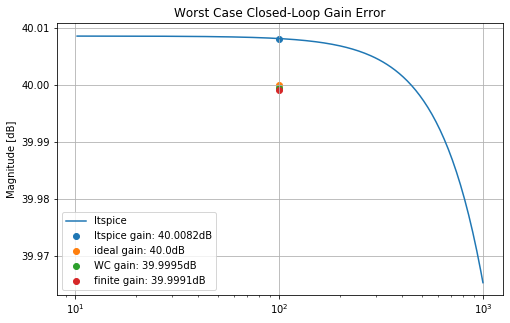

In [10]:
fig, ax = plt.subplots(1,figsize=(8,5))
ax.set_title(r'Worst Case Closed-Loop Gain Error')
ax.semilogx(freq, mag, label='ltspice')
ax.scatter(freq.iloc[x0],[mag100], label=f'ltspice gain: {round(mag100,4)}dB')
ax.scatter([100],[20*np.log10(100)], label=f'ideal gain: {round(20*np.log10(100),4)}dB')
ax.scatter([100],[magwc], label=f'WC gain: {round(magwc,4)}dB')
ax.scatter([100],[20*np.log10(99.99)], label=f'finite gain: {round(20*np.log10(99.99),4)}dB')
ax.set_ylabel('Magnitude [dB]')
ax.grid()
ax.legend()
plt.show();

**Part E.3**

In [11]:
filepath = 'data/instrumentation_amp_CL_vid.txt'
filepath2 = 'data/instrumentation_amp_CL_vcm.txt'
df = read_ltspice(filepath,'ac','db')
df2 = read_ltspice(filepath2,'ac','db')
mag1 = df['Mag_V(vout)']
ang1 = df['Phase_V(vout)']
mag2 = df2['Mag_V(vout)']
ang2 = df2['Phase_V(vout)']
freq = df['Freq.']
print(f'Common Mode Rejection Ratio: {round(max(mag1)-max(mag2),4)}dB')

Common Mode Rejection Ratio: 93.9792dB


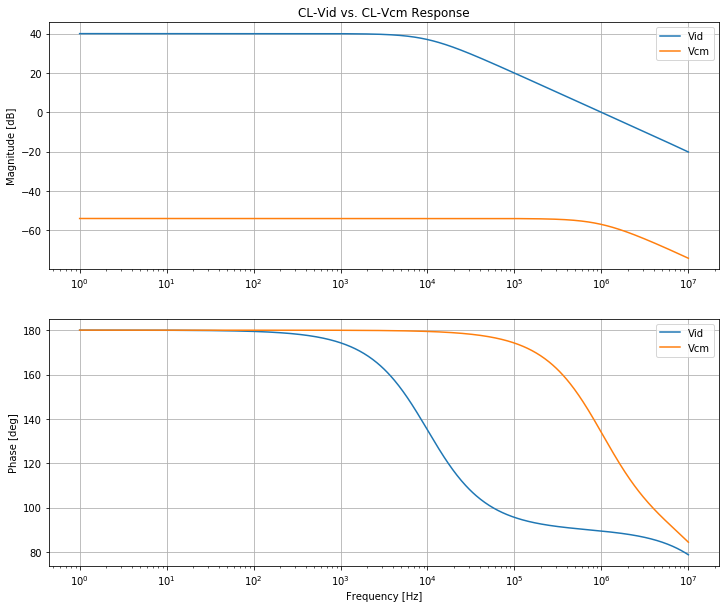

In [12]:
#Plot
fig, axs = plt.subplots(2,figsize=(12,10))
axs[0].set_title('CL-Vid vs. CL-Vcm Response')
axs[0].semilogx(freq, mag1, label='Vid')
axs[0].semilogx(freq, mag2, label='Vcm')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()
axs[1].semilogx(freq, ang1, label='Vid')
axs[1].semilogx(freq, ang2, label='Vcm')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Phase [deg]')
axs[1].grid()
axs[1].legend()
plt.show();